# Импортирование данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap

df=pd.read_csv('/content/drive/MyDrive/Project_chicago/Crime Prediction in Chicago_Dataset (1).csv')

# Обработка датасета (работа с пропусками)

Разделение даты на временные промежутки:

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour

Заполнение пропусков модой (для категориальных данных) или средним/медианным значением (для числовых данных):

In [ ]:
df['Location Description'].fillna(df['Location Description'].mode()[0],inplace=True)
df['Latitude'].fillna(df['Latitude'].mean(),inplace=True)
df['Longitude'].fillna(df['Longitude'].mean(),inplace=True)
df['Ward'].fillna(df['Ward'].mean(),inplace=True)
df['X Coordinate'].fillna(df['X Coordinate'].mean(),inplace=True)
df['Y Coordinate'].fillna(df['Y Coordinate'].mean(),inplace=True)

<ipython-input-147-3a1c996d860b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Location Description'].fillna(df['Location Description'].mode()[0],inplace=True)
<ipython-input-147-3a1c996d860b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

In [ ]:
def set_daytime(hour):
  if 23 <= hour or hour < 5:
    return 'Night'
  elif 5 <= hour < 12:
    return 'Morning'
  elif 12 <= hour < 17:
    return 'Afternoon'
  else:
    return 'Evening'

df['Time_of_Day'] = df['Hour'].apply(set_daytime)

# Построение матрицы корреляций для числовых переменных

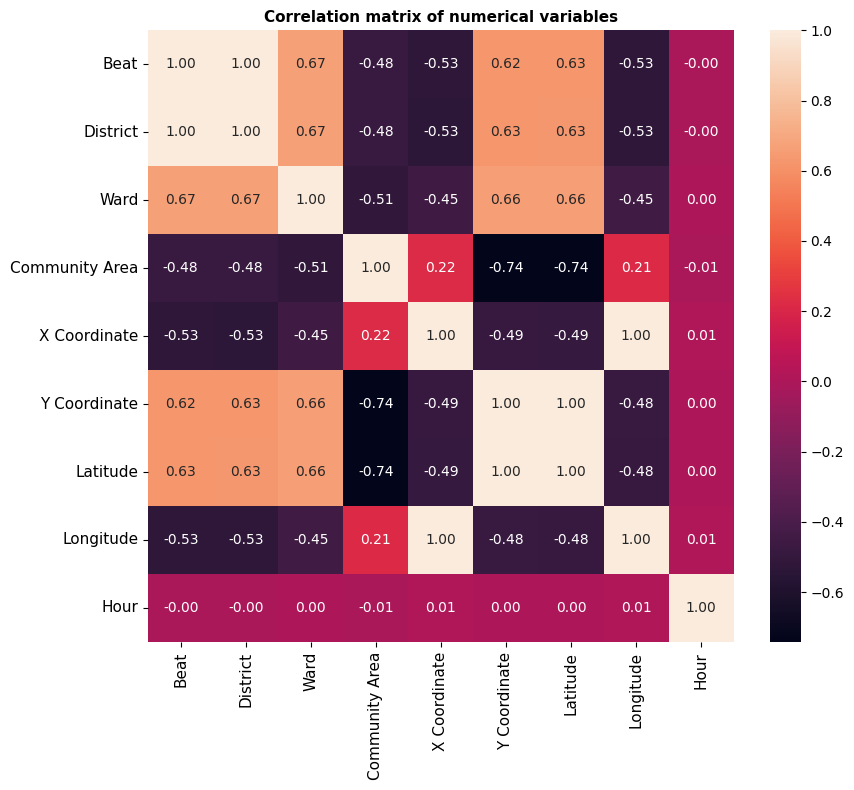

In [ ]:
plt.figure(figsize=(9,8))
sns.heatmap(df.drop(columns=['ID', 'Arrest', 'Year', 'Domestic','Date','Day_of_Week','Month','Day']).corr(numeric_only = True), annot=True, fmt='.2f')
plt.title('Correlation matrix of numerical variables', fontsize=11,fontweight='bold')
plt.tick_params(labelsize=11)
plt.tight_layout()
plt.show()

Переменные Beat, District и Ward  имеют положительную корреляцию между собой (от 0.67 до 1). Почему же это так? Скорее всего преступления определенных типов совершаются в конкретных районах местности, за что и отвечают эти три переменные. Координаты по X и Y полностью коррелируют с широтой и долготой, что правда, ведь по сути они одно и то же. В приниципе, мы можем избавиться от колонок с широтой и долготой, для построения карты будем пользоваться переменными X Coordinate, Y Coordinate.

# Построение гипотез

In [ ]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Year,Updated On,Latitude,Longitude,Location,Month,Day,Day_of_Week,Hour,Time_of_Day
0,12592454,JF113025,2022-01-14 15:55:00,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,2022,9/14/2023 15:41,41.771782,-87.649437,"(41.771782439, -87.649436929)",1,14,4,15,Afternoon
1,12785595,JF346553,2022-08-05 21:00:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,2022,9/14/2023 15:41,41.763338,-87.597001,"(41.763337967, -87.597001131)",8,5,4,21,Evening
2,12808281,JF373517,2022-08-14 14:00:00,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,2022,9/14/2023 15:41,41.985875,-87.766404,"(41.985875279, -87.766403857)",8,14,6,14,Afternoon
3,12888104,JF469015,2022-11-10 03:47:00,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,2022,9/14/2023 15:41,41.762615,-87.652840,"(41.76261474, -87.652840463)",11,10,3,3,Night
4,13209277,JG422539,2022-08-15 09:00:00,0000X W JACKSON BLVD,810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,2022,9/14/2023 15:43,41.845612,-87.668599,NaN,8,15,0,9,Morning


**Гипотеза 1**.

Нулевая гипотеза H0: среднее количество краж (THEFT) в выходные дни не отличается от среднего количества краж в будние дни. Альтернативная гипотеза H1: среднее количество краж в выходные дни отличается от среднего количества краж в будние дни. На основе исследований, кражи в выходные дни совершаются чаще, чем в будни, проверим это. Для проверки зависимости между средними двух категориальных переменных используем t-тест.

In [ ]:
from scipy.stats import ttest_ind

theft = df[df['Primary Type'] == 'THEFT']

cnt = theft['Day_of_Week'].value_counts().sort_index()

t_st, p_val = ttest_ind(cnt.loc[5:],cnt.loc[0:4])

print('Среднее количество краж в выходные =',sum(cnt.loc[5:])/2)
print('Среднее количество краж в будни = ',sum(cnt.loc[0:4])/5)
print('p-значения =',p_val)
print('t-статистика =',t_st)
print('Отклоняем H0, принимаем H1') if p_val < 0.05 else print('Не отклоняем H0, не принимаем H1')

Среднее количество краж в выходные = 7440.0
Среднее количество краж в будни =  8001.2
p-значения = 0.19341649769719804
t-статистика = -1.5019586635221644
Не отклоняем H0, не принимаем H1


День недели, в который происходят кражи, не имеет значительных различий в зависимости от того, является ли день выходным или будним. В нашем случае p = 0.19 - не отклоняем нулевую гипотезу. Это означает, что нет достаточных доказательств, чтобы утверждать, что средние значения различаются.

**Гипотеза 2**.

Можно заметить связь муниципальных округов (Community Area) и широт (Latitude),чем больше значение Community Area, тем меньше значение Latitude. Нулевая гипотеза H0: нет статистически значимой корреляции между муниципальным округом и широтой. Альтернативная гипотеза H1: существует статистически значимая отрицательная корреляция.
Для проверки значимости коэффициента корреляции используем  t-тест Пирсона, так как у нас две количественные переменные.

In [ ]:
from scipy.stats import pearsonr

cor, p_val = pearsonr(df['Community Area'], df['Latitude'])

print('Коэффициент корреляции Пирсона =',cor)
print('p-значения =',p_val)
print('Отклоняем H0, принимаем H1') if p_val < 0.05 and cor<0 else print('Не отклоняем H0, не принимаем H1')

Коэффициент корреляции Пирсона = -0.7411858982016424
p-значения = 0.0
Отклоняем H0, принимаем H1


p-значение = 0.0, значит корреляция статистически значима и мы можем отклонить нулевую гипотезу H0, которая утверждает, что между переменными нет корреляции. В таком случаем принимаем альтернативную. Значит, отрицательная корреляция между муниципальным округом и широтой возникла не случайно и мы это проверили.

In [ ]:
type_counts = df['Primary Type'].value_counts()
print("Топ-5 типов преступлений:")
print(type_counts.head())

# Сравним THEFT и BATTERY с остальными
top_two = type_counts[['THEFT', 'BATTERY']].sum()
others = type_counts.sum() - top_two
print(f"\nTHEFT + BATTERY: {top_two} случаев")
print(f"Прочие типы: {others} случаев")

# Хи-квадрат тест
observed = [top_two, others]
expected = [sum(observed)/2] * 2
chi_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"\nChi-squared test: χ² = {chi_stat:.2f}, p = {p_value:.4f}")
if p_value < 0.05:
    print("Принимаем H0: THEFT и BATTERY действительно преобладают.")
else:
    print("Отклоняем H1")

H0:THEFT и BATTERY встречаются значительно чаще, чем другие типы преступлений. Их доля в общем числе преступлений существенно выше, чем можно было бы ожидать при равномерном распределении.Наиболее распространёнными типами преступлений являются кражи (THEFT) и нападения (BATTERY).
H1:Тип преступления (Primary Type) распределён равномерно или слабо отличается.
THEFT и BATTERY не встречаются значительно чаще, чем другие типы.
Хи-квадрат тест проверяет, насколько наблюдаемое распределение категориальных данных (в нашем случае — количество преступлений по типу) отличается от ожидаемого распределения.
Принимаем нулевую гипотезу

In [ ]:
# сопряженность: тип и факт ареста
contingency = pd.crosstab(df['Primary Type'], df['Arrest'])

# Отдельно выделим строку по наркотикам
narcotics_vs_arrest = contingency.loc[['NARCOTICS']].values
other_vs_arrest = contingency.drop('NARCOTICS').sum().values

# создадим таблицу 2x2
table = pd.DataFrame(
    [narcotics_vs_arrest[0], other_vs_arrest],
    index=['NARCOTICS', 'Other'],
    columns=['Not Arrested', 'Arrested']
)
chi2, p, dof, expected = chi2_contingency(table)
print("таблица:")
print(table)
print(f"\nChi-squared = {chi2:.2f}, p = {p:.4f}")

if p < 0.05:
    print("Принимаем H0: NARCOTICS действительно чаще приводит к арестам.")
else:
    print("Отклоняем H1")

H0:Вероятность ареста зависит от типа преступления, и для NARCOTICS вероятность ареста значимо выше, чем для других преступлений.
H1:Вероятность ареста не зависит от типа преступления. Т.е. преступления, связанные с наркотиками (NARCOTICS), не чаще приводят к арестам, чем другие типы.

Некоторые типы преступлений (например, наркотики — NARCOTICS) чаще приводят к арестам. Принимаем нулевую гипотезу

In [2]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

df = pd.read_csv('crive.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

**Гипотеза 3**

H0: Доля арестов ночью не меньше, чем днём  
H1: Доля арестов ночью меньше, чем днём
  
Две независимые группы (ночь и день), бинарный исход (Arrest: да/нет) => z-тест, т.к. сравниваем доли

In [4]:
df['hour'] = df['Date'].dt.hour
df['is_night'] = (df['hour'] >= 20) | (df['hour'] <= 5)
df['Arrest'] = df['Arrest'].astype(bool)

night = df[df['is_night']]
day = df[~df['is_night']]

count = [night['Arrest'].sum(), day['Arrest'].sum()]
nobs = [len(night), len(day)]

z_stat, p_val = proportions_ztest(count, nobs, alternative='smaller')

print(f"Доля арестов ночью: {count[0]}/{nobs[0]} = {round(count[0]/nobs[0], 4)}")
print(f"Доля арестов днём: {count[1]}/{nobs[1]} = {round(count[1]/nobs[1], 4)}")
print(f"Z-статистика: {z_stat}")
print(f"p-значение: {p_val}")
if p_val < 0.05:
  print("Отклоняем H0. Арестов ночью статистически меньше — гипотеза подтверждается")
else:
  print("Не отклоняем H0. Недостаточно оснований считать, что арестов ночью меньше")

Доля арестов ночью: 11308/92600 = 0.1221
Доля арестов днём: 16745/146958 = 0.1139
Z-статистика: 6.057772585318114
p-значение: 0.9999999993099034
Не отклоняем H0. Недостаточно оснований считать, что арестов ночью меньше


**Гипотеза 4**
    
H0: Среднее количество преступлений в тёплые месяцы = в холодные  
H1: Среднее количество преступлений в тёплые месяцы > чем в холодные
  
Две независимые группы (тёплые и холодные месяцы), количественная переменная (число преступлений в день) => t-тест для сравнения средних (числовые)

In [6]:
df['month'] = df['Date'].dt.month
df['is_warm'] = df['month'].between(4, 9)

daily_counts = df.groupby([df['Date'].dt.date, 'is_warm']).size().unstack(fill_value=0)
warm = daily_counts[True]
cold = daily_counts[False]

t_stat, p_val = ttest_ind(warm, cold, alternative='greater', equal_var=False)

print(f"Среднее количество преступлений в тёплые месяцы: {round(warm.mean(), 1)}")
print(f"Среднее количество преступлений в холодные месяцы: {round(cold.mean(), 1)}")
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_val}")
if p_val < 0.05:
  print("Отклоняем H0. В тёплые месяцы совершается статистически больше преступлений")
else:
  print("Не отклоняем H0. Недостаточно оснований считать, что в тёплые месяцы преступлений больше")

Среднее количество преступлений в тёплые месяцы: 345.5
Среднее количество преступлений в холодные месяцы: 310.8
t-статистика: 1.3991065635571447
p-значение: 0.08110485863591302
Не отклоняем H0. Недостаточно оснований считать, что в тёплые месяцы преступлений больше


**Гипотеза 5**  
  
H0: Среднее количество преступлений в выходные <= в будни  
H1: Среднее количество преступлений в выходные > чем в будни
  
Аналогично гипотезе 4 - t-тест (сравниваем среднее количество преступлений)

In [7]:
df['dow'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dow'].isin([5, 6])

daily_counts = df.groupby([df['Date'].dt.date, 'is_weekend']).size().unstack(fill_value=0)
weekend = daily_counts[True]
weekday = daily_counts[False]

t_stat, p_val = ttest_ind(weekend, weekday, alternative='greater', equal_var=False)

print(f"Среднее количество преступлений в выходные: {round(weekend.mean(), 1)}")
print(f"Среднее количество преступлений в будни: {round(weekday.mean(), 1)}")
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_val}")
if p_val < 0.05:
  print("Отклоняем H0. В выходные совершается статистически больше преступлений")
else:
  print("Не отклоняем H0. Недостаточно оснований считать, что в выходные преступлений больше")

Среднее количество преступлений в выходные: 187.4
Среднее количество преступлений в будни: 468.9
t-статистика: -12.482838656031557
p-значение: 1.0
Не отклоняем H0. Недостаточно оснований считать, что в выходные преступлений больше


**Гипотеза 6**  
  
H0: Доля арестов при насильственных преступлениях <= при ненасильственных  
H1: Доля арестов при насильственных преступлениях > при ненасильственных
  
Сравниваем доли арестов между двумя группами => z-тест

In [8]:
df['Primary Type'] = df['Primary Type'].astype(str)
df['is_violent'] = df['Primary Type'].isin(['BATTERY', 'ASSAULT', 'HOMICIDE', 'ROBBERY', 'CRIM SEXUAL ASSAULT'])
df['Arrest'] = df['Arrest'].astype(bool)

count = [df[df['is_violent']]['Arrest'].sum(), df[~df['is_violent']]['Arrest'].sum()]
nobs = [df['is_violent'].sum(), (~df['is_violent']).sum()]

z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

print(f"Доля арестов при насильственных: {count[0]}/{nobs[0]} = {round(count[0]/nobs[0], 4)}")
print(f"Доля арестов при ненасильственных: {count[1]}/{nobs[1]} = {round(count[1]/nobs[1], 4)}")
print(f"Z-статистика: {z_stat}")
print(f"p-значение: {p_val}")
if p_val < 0.05:
  print("Отклоняем H0. Насильственные преступления действительно чаще приводят к аресту")
else:
  print("Не отклоняем H0. Недостаточно оснований считать, что арестов при насильственных преступлениях больше")

Доля арестов при насильственных: 8795/71450 = 0.1231
Доля арестов при ненасильственных: 19258/168108 = 0.1146
Z-статистика: 5.944195084267635
p-значение: 1.389092906750476e-09
Отклоняем H0. Насильственные преступления действительно чаще приводят к аресту


**Гипотеза 7**  
  
H0: Доля арестов при домашних преступлениях <= при недомашних  
H1: Доля арестов при домашних преступлениях > при недомашних
  
Аналогично прошлой гипотезе (сравнение долей в двух выборках) => z-тест

In [9]:
df['Domestic'] = df['Domestic'].astype(bool)
df['Arrest'] = df['Arrest'].astype(bool)

count = [df[df['Domestic']]['Arrest'].sum(), df[~df['Domestic']]['Arrest'].sum()]
nobs = [df['Domestic'].sum(), (~df['Domestic']).sum()]

z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

print(f"Доля арестов при домашних: {count[0]}/{nobs[0]} = {round(count[0]/nobs[0], 4)}")
print(f"Доля арестов при недомашних: {count[1]}/{nobs[1]} = {round(count[1]/nobs[1], 4)}")
print(f"Z-статистика: {z_stat}")
print(f"p-значение: {p_val}")
if p_val < 0.05:
  print("Отклоняем H0. Домашние преступления действительно чаще заканчиваются арестом")
else:
  print("Не отклоняем H0. Недостаточно оснований считать, что арестов при домашних преступлениях больше")

Доля арестов при домашних: 5652/44916 = 0.1258
Доля арестов при недомашних: 22401/194642 = 0.1151
Z-статистика: 6.384816780778471
p-значение: 8.580140086191872e-11
Отклоняем H0. Домашние преступления действительно чаще заканчиваются арестом
